<h1 style="text-align: center;">✨THE LUSCHER ZETA FUNCTION✨</h1>


In [19]:
import numpy as np
import pandas as pd
from scipy.special import sph_harm
from scipy.integrate import quad
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

💭What is the Luscher Zeta Function?💭 \
The Lüscher zeta function connects finite-volume energy levels to scattering phase shifts. It helps extract physical observables from lattice QCD simulations. This is crucial for studying hadron interactions and resonances. It has an infinte sum term and an integral term which we will split in three separate terms. Our goal is to code the luscher zeta function and we will begin with the infinte sum term.

In [20]:
def spherical_harmonic(l, m, theta, phi):
    return sph_harm(m, l, phi, theta)

def norm_squared(n):
    return n @ n

In [21]:
def generate_lattice_points(L_max):
    """
    Generate lattice points during computation.
    """
    for x in range(-L_max, L_max + 1):
        for y in range(-L_max, L_max + 1):
            for z in range(-L_max, L_max + 1):
                n = np.array([x, y, z])
                if np.any(n != 0):  # Exclude the origin
                    r2 = norm_squared(n)
                    r = np.sqrt(r2)
                    theta = np.arccos(n[2] / r) if r > 0 else 0.0
                    phi = np.arctan2(n[1], n[0])
                    yield r2, theta, phi

def Z_l(s, q2, ell, L_max, epsilon):
    """
    Z_l(s, q^2) for large lattices. (If needed)
    """
    Z_l_value = 0.0 + 0.0j  # Initialize with zero (complex)
    for r2, theta, phi in generate_lattice_points(L_max):
        denominator = (r2 - q2) + epsilon * 1j
        Y_lm = spherical_harmonic(ell, 0, theta, phi)
        Z_l_value += Y_lm / denominator
    return Z_l_value

def compute_Z_l_for_q2(q2, s, ell, L_max, epsilon):
    """
    Wrapper function for computing Z_l for a given q2.
    """
    return Z_l(s, q2, ell, L_max, epsilon)

In [22]:
# Parameters
s = 1.0  # Scaling parameter (fixed to 1.0)
ell = 4  # spherical harmonic
L_max = 10
epsilon = 1e-3  # Regularisation parameter

# q^2 range
q2_values = np.arange(-1.0001, 5.0, 0.001)

# Parallel computation of Z_l over q2_values
Z_l_results = Parallel(n_jobs=-1)(
    delayed(compute_Z_l_for_q2)(q2, s, ell, L_max, epsilon)
    for q2 in q2_values
)

We are now ready to plot the infinte sum term(🥳).

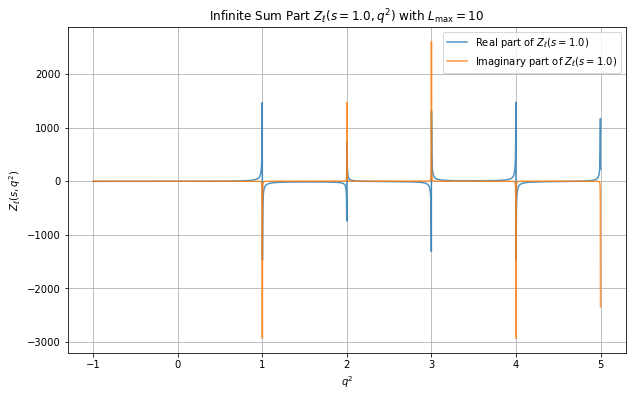

In [23]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(q2_values, [z.real for z in Z_l_results], label=f'Real part of $Z_{{\ell}}(s={s})$', alpha=0.8)
plt.plot(q2_values, [z.imag for z in Z_l_results], label=f'Imaginary part of $Z_{{\ell}}(s={s})$', alpha=0.8)

# Highlight divergence points
#for r2, _, _ in lattice_points:
#    if -1.0 <= r2 <= 5.0:
#        plt.axvline(r2, color='red', linestyle='--', alpha=0.3)

plt.xlabel('$q^2$')
plt.ylabel(f'$Z_{{\ell}}(s, q^2)$')
plt.title(f'Infinite Sum Part $Z_{{\ell}}(s={s}, q^2)$ with $L_\mathrm{{max}}={L_max}$')
plt.legend()
plt.grid(True)
plt.show()

The infinite sum term looks like it behaves as a tan as expected.

-----------------------------------***NOW WE WILL DO THE INTEGRAL TERM🚀💫📚***------------------------------------

The integral term $ I(q^2) $ can be separated to three distinct parts to handle different momentum regions. We have:

### 1. Low-Momentum Contribution 

This integral represents the contribution from the low-momentum region, where the momentum $ r $ is small. It is integrated from $ 0 $ to an intermediate cutoff $ \Lambda_{\text{low}} $, which avoids the singularity near $ r = \sqrt{q^2} $.

$$
I_{\text{low}}(q^2) = \int_{0}^{\Lambda_{\text{low}}} \frac{r^2 \, dr}{(2\pi)^3} \frac{Y_\ell(\hat{\mathbf{r}})}{r^2 - q^2}
$$

### 2. Singular Region Contribution

This integral handles the contribution from the region near the singularity at $ r = \sqrt{q^2} $. To properly deal with the singularity, the integral is split into two parts: one just below $ \sqrt{q^2} $ and one just above it. A small exclusion region of size $ \delta $ is used around the singularity, and the **principal value** (P.V.) of the integral is taken.

$$
I_{\text{sing}}(q^2) = \text{P.V.} \left( \int_{\Lambda_{\text{low}}}^{\sqrt{q^2} - \delta} \frac{r^2 \, dr}{r^2 - q^2} + \int_{\sqrt{q^2} + \delta}^{\Lambda_{\text{high}}} \frac{r^2 \, dr}{r^2 - q^2} \right)
$$

### 3. High-Momentum Contribution 

This integral represents the contribution from the high-momentum region, where the momentum $ r $ is large. It is integrated from a high cutoff $ \Lambda_{\text{high}} $ to infinity. To ensure proper convergence, an asymptotic approximation is used for the tail of the integral.

$$
I_{\text{high}}(q^2) = \int_{\Lambda_{\text{high}}}^{\infty} \frac{r^2 \, dr}{(2\pi)^3} \frac{Y_\ell(\hat{\mathbf{r}})}{r^2 - q^2}
$$

Total Integral

The total integral $ I(q^2) $ is obtained by summing the three contributions:

$$
I(q^2) = I_{\text{low}}(q^2) + I_{\text{sing}}(q^2) + I_{\text{high}}(q^2)
$$



In [ ]:
# Define angular integral normalisation
def angular_integral(ell):
    return (2 * ell + 1) / (4 * np.pi)

# Radial integrand
def integrand(r, q2, ell, alpha, epsilon):
    angular_weight = angular_integral(ell)
    adjusted_r2 = r**2 / alpha**2  # Scale r^2 by alpha^2
    return (r**2 / alpha**2) * angular_weight / (adjusted_r2 - q2 + epsilon)

# Low-momentum integral
def I_low(q2, ell, Lambda_low, alpha, epsilon):
    result, _ = quad(integrand, 0, Lambda_low, args=(q2, ell, alpha, epsilon), epsabs=1e-7, epsrel=1e-7)
    return result / (2 * np.pi**2)

# Singular momentum integral
def I_sing(q2, ell, Lambda_low, Lambda_high, alpha, epsilon, delta=1e-3):
    left_integral, _ = quad(
        integrand, Lambda_low, np.sqrt(q2) - delta, args=(q2, ell, alpha, epsilon),
        epsabs=1e-7, epsrel=1e-7
    )
    right_integral, _ = quad(
        integrand, np.sqrt(q2) + delta, Lambda_high, args=(q2, ell, alpha, epsilon),
        epsabs=1e-7, epsrel=1e-7
    )
    return (left_integral + right_integral) / (2 * np.pi**2)

# High-momentum integral
def I_high(q2, ell, Lambda_high, alpha, epsilon):
    result, _ = quad(
        integrand, Lambda_high, np.inf, args=(q2, ell, alpha, epsilon), limit=500,
        epsabs=1e-7, epsrel=1e-7
    )
    return result / (2 * np.pi**2)

# Total integral
def total_integral(q2, ell, Lambda_low, Lambda_high, alpha, epsilon):
    I_low_val = I_low(q2, ell, Lambda_low, alpha, epsilon)
    I_sing_val = I_sing(q2, ell, Lambda_low, Lambda_high, alpha, epsilon)
    I_high_val = I_high(q2, ell, Lambda_high, alpha, epsilon)
    return I_low_val + I_sing_val + I_high_val


In [ ]:
# Full F(q^2, Lambda_high)
def F(q2, s, ell, L_max, epsilon, Lambda_low, Lambda_high, alpha):
    Z_l_val = Z_l(s, q2, ell, L_max, epsilon)
    integral_val = total_integral(q2, ell, Lambda_low, Lambda_high, alpha, epsilon)
    return Z_l_val + integral_val

# Function to plot F vs Lambda_high for a fixed alpha
def plot_F_vs_Lambda_high(Lambda_high_values, F_values, q2, alpha):
    """
    Plot F(q^2, Lambda_high) vs Lambda_high for a fixed alpha.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot the real and imaginary parts of F
    plt.plot(Lambda_high_values, [np.real(f) for f in F_values], label="Real part of $F$", alpha=0.8)
    # plt.plot(Lambda_high_values, [np.imag(f) for f in F_values], label="Imaginary part of $F$", alpha=0.8, linestyle="--")

    # Add labels, title, and grid
    plt.xlabel(r"$\Lambda_{\mathrm{high}}$", fontsize=14)
    plt.ylabel(r"$F(q^2, \Lambda_{\mathrm{high}})$", fontsize=14)
    plt.title(f"$F(q^2, \\Lambda_{{\\mathrm{{high}}}})$ vs $\\Lambda_{{\\mathrm{{high}}}}$ for $q^2={q2}$, $\\alpha={alpha}$", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


Let's plot that!

<ipython-input-24-46285dec33b8>:22: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  right_integral, _ = quad(
<ipython-input-24-46285dec33b8>:30: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(


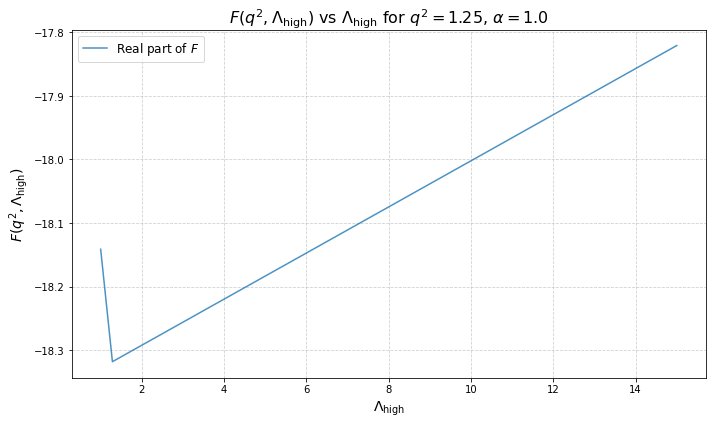

In [31]:
# Parametres for analysis
s = 1.0
ell = 4
L_max = 10
epsilon = 1e-3
Lambda_low = 0.5
q2 = 1.25  # Fixed energy
alpha = 1.0  # Fixed alpha
Lambda_high_values = np.linspace(1.0, 15.0, 50)  # Range of Lambda_high

# Compute F(q^2, Lambda_high) for the fixed alpha
F_values = [
    F(q2, s, ell, L_max, epsilon, Lambda_low, Lambda_high, alpha)
    for Lambda_high in Lambda_high_values
]

# Plot F vs Lambda_high
plot_F_vs_Lambda_high(Lambda_high_values, F_values, q2, alpha)

In [ ]:
# Function to plot normalised F
def plot_normalized_F(results_df):
    plt.figure(figsize=(10, 6))
    for alpha in sorted(results_df["Alpha"].unique()):
        subset = results_df[results_df["Alpha"] == alpha]
        plt.plot(
            subset["Lambda_high"],
            subset["F_total"] / subset["Lambda_high"],
            label=f"Normalized F, alpha = {alpha}"
        )
    plt.xlabel(r"$\Lambda_{\mathrm{high}}$", fontsize=14)
    plt.ylabel(r"$F(q^2, \Lambda_{\mathrm{high}})/\Lambda_{\mathrm{high}}$", fontsize=14)
    plt.title(r"Normalized $F(q^2, \Lambda_{\mathrm{high}})$ vs $\Lambda_{\mathrm{high}}$ for varying $\alpha$", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()



The following cell will only make sense once i find the literature values to check which is why it is now commeneted out.

In [ ]:
'''# Validation test
def validate_results():
    """
    Compare the results for specific parameters to known analytical or published results.
    Replace reference values with known benchmarks.
    """
    q2 = 1.25
    ell = 4
    s = 1.0
    L_max = 15
    epsilon = 1e-10
    Lambda_low = 0.5
    Lambda_high = 10.0
    alpha = 1.0

    computed_Z_l = Z_l(s, q2, ell, L_max, epsilon)
    computed_F = F(q2, s, ell, L_max, epsilon, Lambda_low, Lambda_high, alpha)
    
    reference_Z_l = # FIND IN A PAPER
    reference_F = # FIND IN A PAPER

    print(f"Computed Z_l: {computed_Z_l}, Reference Z_l: {reference_Z_l}")
    print(f"Computed F: {computed_F}, Reference F: {reference_F}")
    
    # Check for agreement
    Z_l_error = np.abs(computed_Z_l - reference_Z_l) / np.abs(reference_Z_l)
    F_error = np.abs(computed_F - reference_F) / np.abs(reference_F)

    print(f"Relative error in Z_l: {Z_l_error:.6e}")
    print(f"Relative error in F: {F_error:.6e}")


<ipython-input-24-46285dec33b8>:22: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  right_integral, _ = quad(
<ipython-input-24-46285dec33b8>:30: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(
<ipython-input-24-46285dec33b8>:18: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  left_integral, _ = quad(
<ipython-input-24-46285dec33b8>:13: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(integrand, 0, Lambda_low, args=(q2, ell, alpha, epsilon), epsabs=1e-7, epsrel=1e-7)


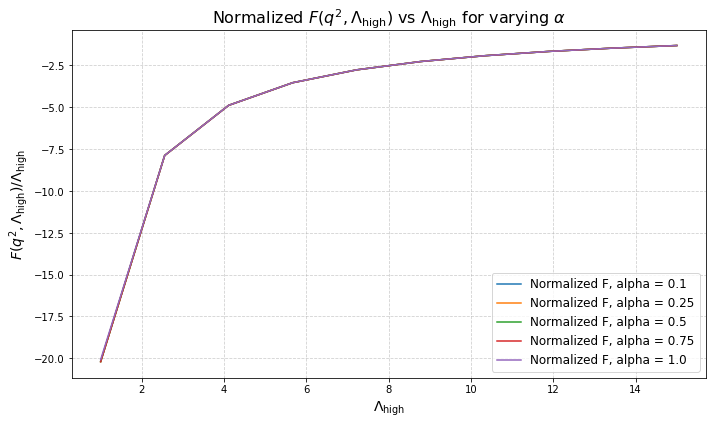

Computed Z_l: (-7.7623172582163145-29619953136.25721j)
Computed F: (-7.435824898357194-29619953136.25721j)


<ipython-input-24-46285dec33b8>:30: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(


In [ ]:
# Parametres for analysis
s = 1.0
ell = 4
L_max = 15
epsilon = 1e-10
Lambda_low = 0.5
q2 = 1.25
alpha_values = [1.0, 0.75, 0.5, 0.25, 0.1]
Lambda_high_values = np.linspace(1.0, 15.0, 10)

# F(q^2, Lambda_high)
results_df = compute_F_with_alpha(alpha_values, Lambda_high_values, s, q2, ell, L_max, epsilon, Lambda_low)

# Plot normalised F
plot_normalized_F(results_df)

# Validate results
validate_results()


That looks as expected! The following plot i for visual purposes only! It is the same plot as above but with offsests so thatt all cures are clearly separated. We see the trens in normalised F(q^2, Lamba_{high} for varying alpha}).⚠️The offsets are not physically meaningful!⚠️ 

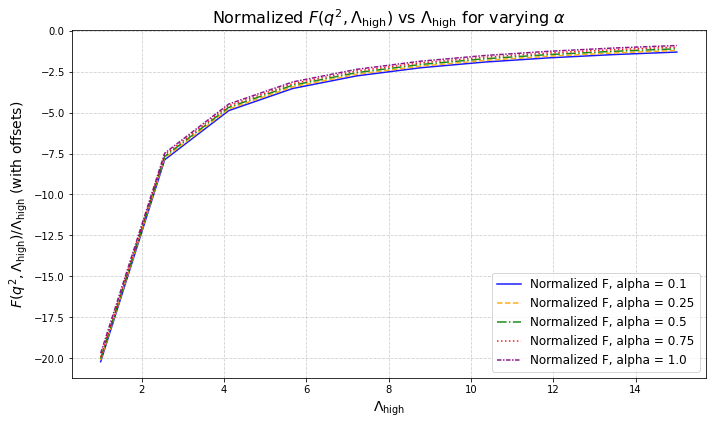

In [ ]:
def plot_normalized_F_with_offsets(results_df):
    plt.figure(figsize=(10, 6))
    
    # Define line styles and colors
    line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
    colors = ['blue', 'orange', 'green', 'red', 'purple']
    
    # Loop over unique alpha values in the results
    for i, alpha in enumerate(sorted(results_df["Alpha"].unique())):
        subset = results_df[results_df["Alpha"] == alpha]
        
        # Add an artificial vertical offset for visualization
        offset = i * 0.1  # Adjust offset value as needed
        plt.plot(
            subset["Lambda_high"],
            (subset["F_total"] / subset["Lambda_high"]) + offset,  # Add offset
            label=f"Normalized F, alpha = {alpha}",
            linestyle=line_styles[i % len(line_styles)],
            color=colors[i % len(colors)],
            alpha=0.9  # Transparency
        )
    
    # Add labels, legend, and grid
    plt.xlabel(r"$\Lambda_{\mathrm{high}}$", fontsize=14)
    plt.ylabel(r"$F(q^2, \Lambda_{\mathrm{high}})/\Lambda_{\mathrm{high}}$ (with offsets)", fontsize=14)
    plt.title(r"Normalized $F(q^2, \Lambda_{\mathrm{high}})$ vs $\Lambda_{\mathrm{high}}$ for varying $\alpha$", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_normalized_F_with_offsets(results_df)
